## Modeling Objetives

### Introduction

After doing the data cleaning and feature selection. We have decided to test models in order to either predict the average ratings of a book or by doing a classification of the book using engineered features.
It would be interesting too to compare models that predict the initial average rating, when using SMOTE algorithm in order to balance the data.

## Steps to follow

#### 1. Preparing the dataset for regression



In [24]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
#dataset = pd.read_excel('Projet Python simulations.xlsx',sheet_name="Python_Dataset")


In [27]:
# We load the dataset and we check the content and the columns
clean_dataset = pd.read_csv('clean_dataset.csv')
display(clean_dataset.columns)
clean_dataset.head()


Index(['Unnamed: 0', 'bookid', 'title', 'authors', 'average_rating', 'isbn',
       'isbn13', 'language_code', 'num_pages', 'ratings_count',
       'text_reviews_count', 'publication_date', 'publisher', 'title2',
       'author2', 'genre', 'multiple_authors', 'n_authors', 'authors_list',
       'main_author', 'ratings_count_updt', 'text_reviews_count_updt',
       'max_pages', 'total_reviews', 'avg_numpages_author',
       'n_pages_vs_avg_auth', 'avg_numpages_publisher', 'n_pages_vs_avg_pub',
       'avg_rating_author', 'rating_vs_avg_auth', 'avg_rating_publisher',
       'rating_vs_avg_pub', 'rating_vs_avg', 'rating_vs_mode', 'pub_month',
       'pub_year', 'pub_month_text', 'season', 'season_num', 'century',
       'language_code_ENgroup', 'log_ratings_count', 'ratings_count_category',
       'ratings_count_category_T', 'log_text_reviews_count_updt',
       'text_reviews_count_category', 'text_reviews_count_category_T',
       'log_total_reviews', 'total_reviews_category',
       'to

,Unnamed: 0,bookid,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,...,language_code_ENgroup_T,genre_T,num_pages_cat,max_pages_cat,num_pages_cat_T,max_pages_cat_T,average_rating_cat,average_rating_cat_T,average_rating_three_cat,average_rating_three_cat_T
0,1847,6549,said the shotgun to the head.,saul williams,4.22,0743470796,9780743470797,en-us,192,2762,...,7057,59595,low,low,2,2,good,4,high,3.0
1,4072,14490,$30 film school: how to write direct produce...,michael w. dean,3.49,1592000673,9781592000678,eng,528,30,...,7057,70172,high,high,4,4,medium,3,low,1.0
2,1574,5415,'salem's lot,stephen king,4.02,0965772411,9780965772419,eng,405,1039,...,7057,73245,high,high,4,4,good,4,medium,2.0
3,3137,11525,1 000 places to see before you die,patricia schultz,3.85,0761104844,9780761104841,eng,992,36303,...,7057,58063,high,high,4,4,good,4,medium,2.0
4,2343,8542,10 lb penalty,dick francis,3.90,042519745X,9780425197455,eng,320,3490,...,7057,80651,medium,medium,3,3,good,4,medium,2.0


In [37]:
# We will only choose numerical data that is not a transformation using the average ratings and we avoid highly correlated variables
regression_columns = ['average_rating','log_ratings_count', 'log_total_reviews','multiple_authors', 'n_authors', 'max_pages', 'season_num','average_rating_three_cat_T']
regression_dataset = clean_dataset[regression_columns]
regression_dataset = regression_dataset[~(regression_dataset['average_rating_three_cat_T'].isna())]
display(regression_dataset.head())

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
0,4.22,3.441239,3.473648,0,1,192,4,3.0
1,3.49,1.478566,1.532754,0,1,528,2,1.0
2,4.02,4.933751,4.937909,0,1,817,4,2.0
3,3.85,4.559944,4.565164,0,1,992,2,2.0
4,3.90,3.542838,3.564323,0,1,320,3,2.0


<AxesSubplot: >

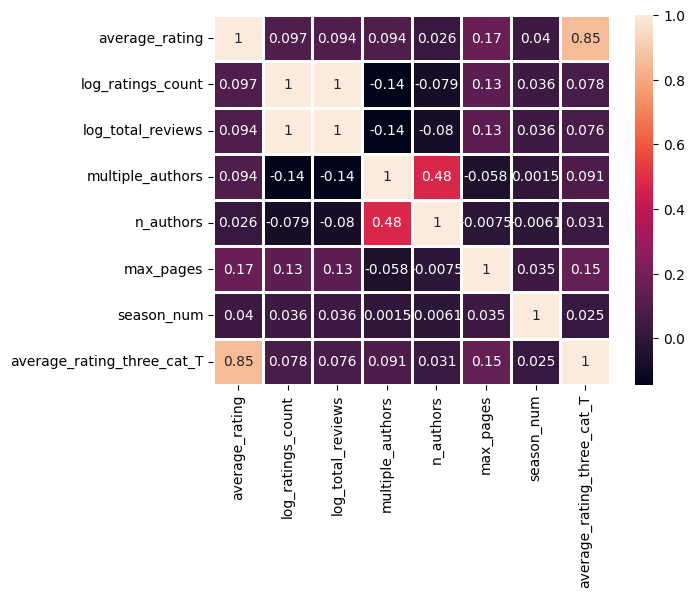

In [38]:
# We observe that average_rating and average_rating_three_cat_T are highly correlated, this is expected as the latter is a transformation of the first into a categorical variable
sns.heatmap(regression_dataset.corr(),annot=True,lw=1)

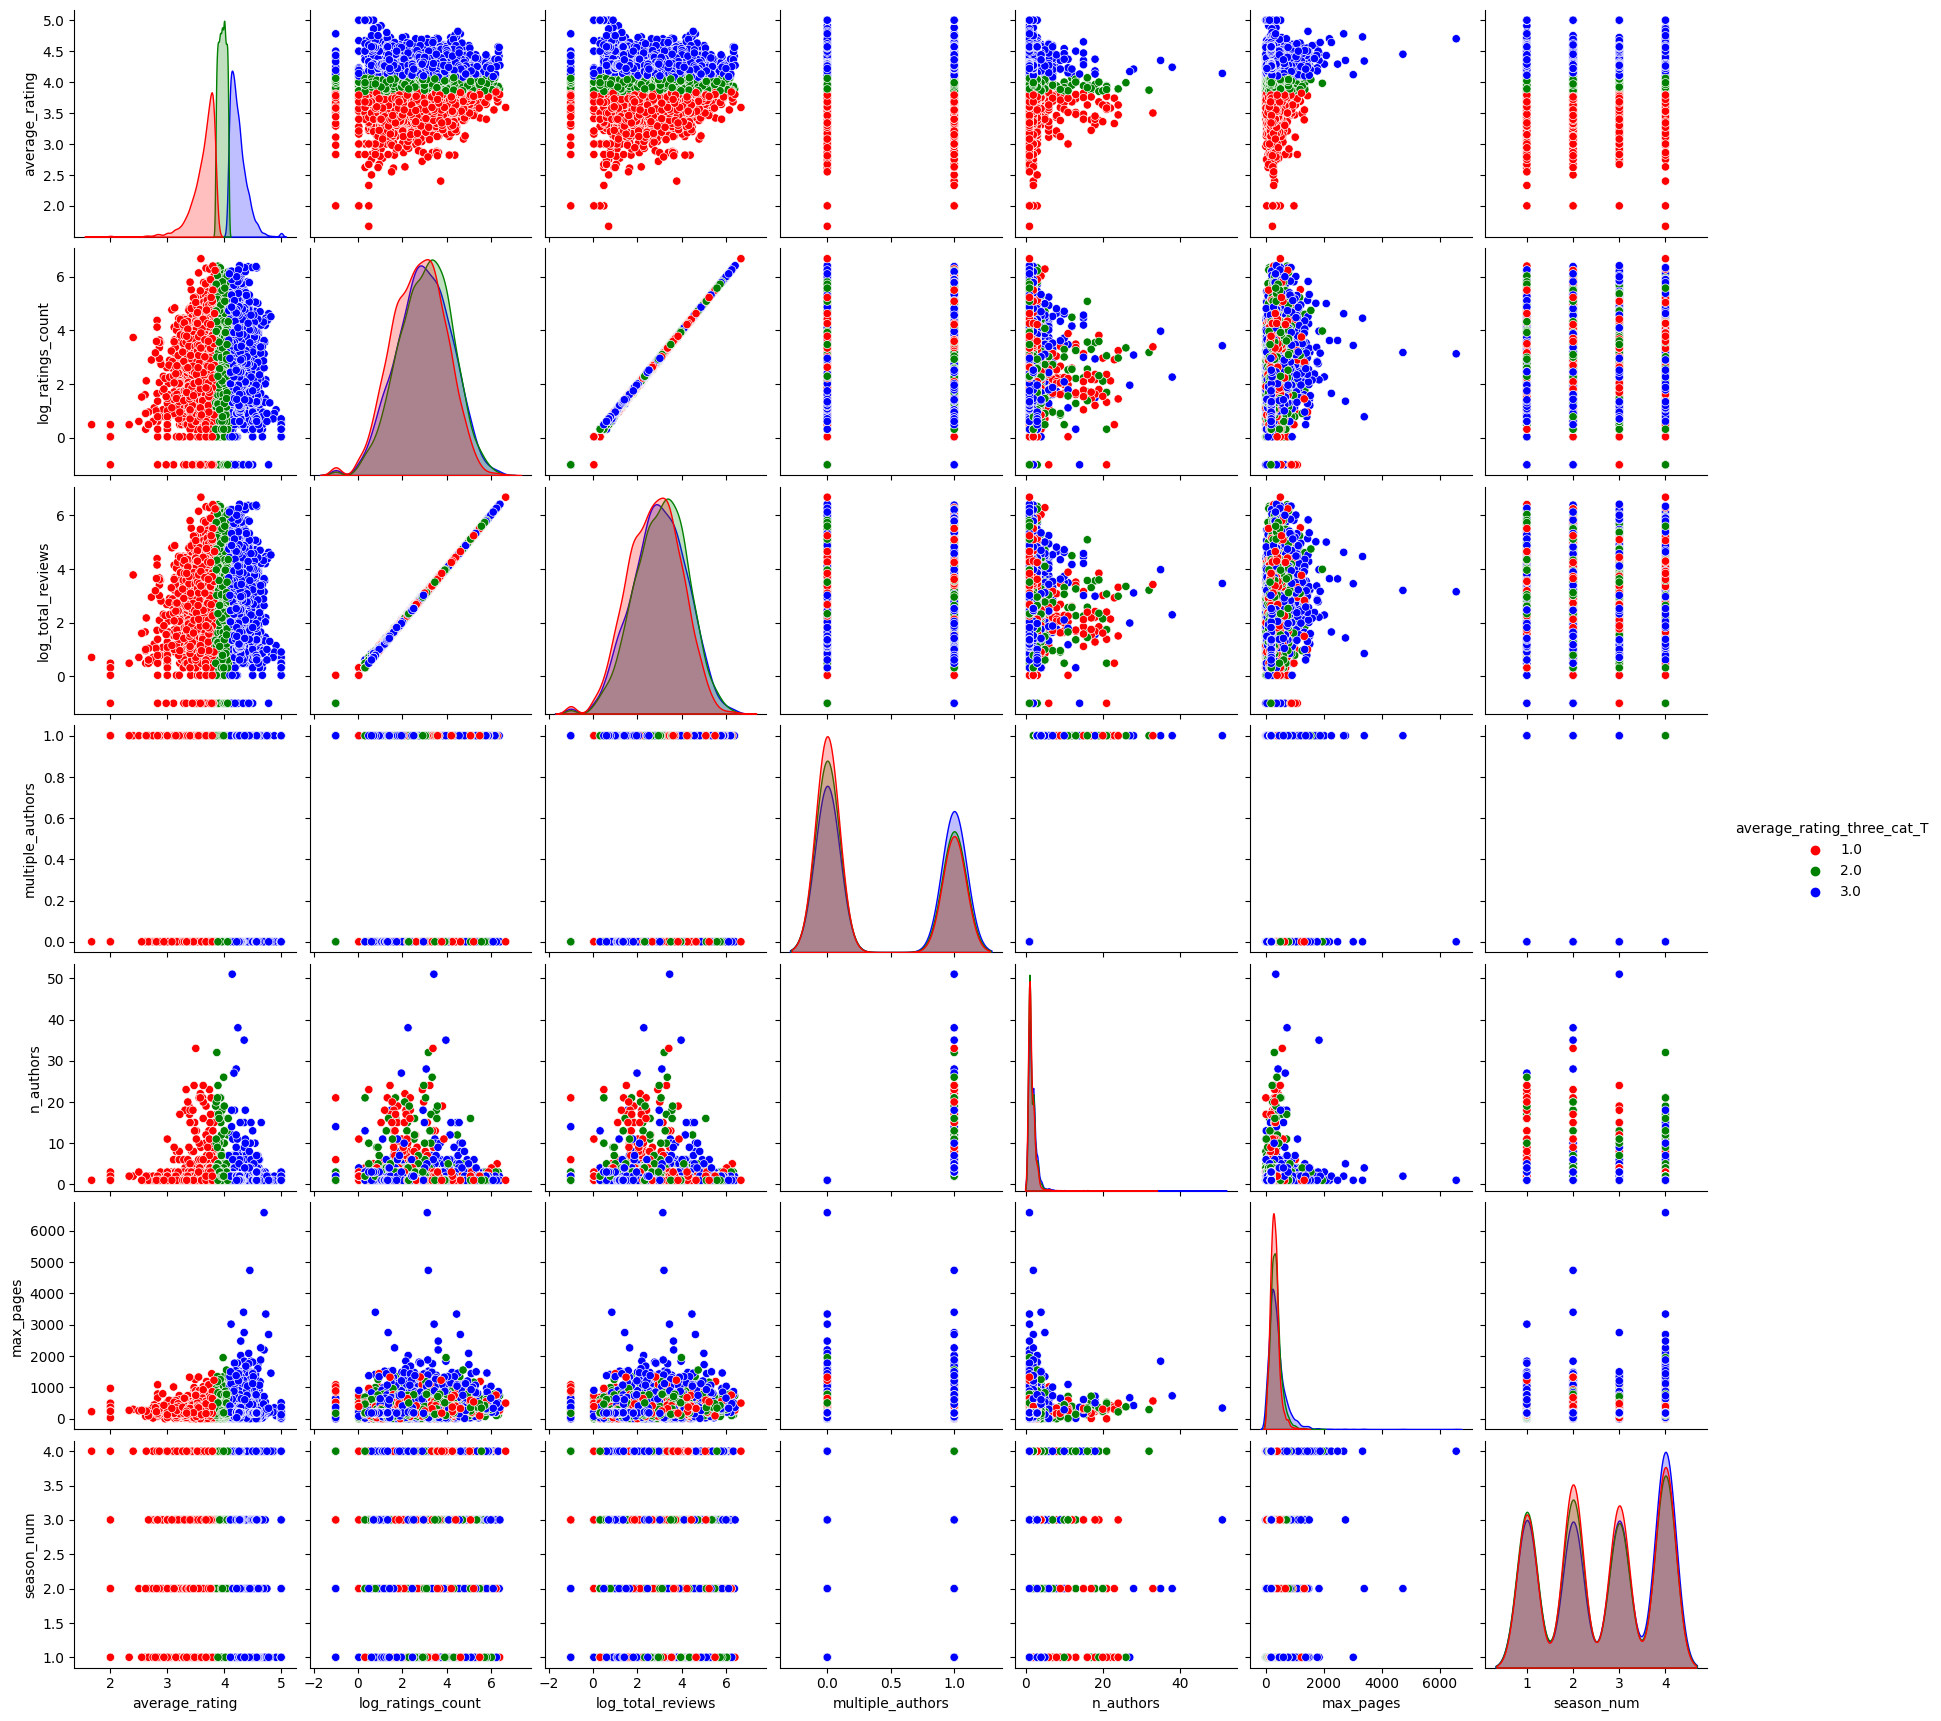

In [39]:
# We observe the distribution of each variable pair by pairs, and we observe the position of our new engineered target category
sns.pairplot(regression_dataset,hue='average_rating_three_cat_T', palette=['r', 'g', 'b'])

In [187]:
# This is a helper function that helps transform categorical data into dummies, to adapt the data for the regression
def from_categoric_to_dummies(columns,dataset):
    dummies = []
    for col in columns:
        dummies.append(pd.get_dummies(dataset[col], prefix=col, prefix_sep='_'))
    new_dataset = pd.concat([dataset, *dummies], axis=1)
    new_dataset = new_dataset.drop(columns, axis=1)
    return new_dataset

In [41]:
#we will create two datasets: one containing the average_ratings and a second containing the transformation of this target column into 3 different categories
regression_dataset_avg_rating_cat = regression_dataset.drop('average_rating', axis=1)
regression_dataset_avg_rating = regression_dataset.drop('average_rating_three_cat_T', axis=1)

In [42]:
# We generate dummies for the categories, pub_month and season_num
regression_dataset_avg_rating_cat = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating_cat)
regression_dataset_avg_rating = from_categoric_to_dummies(['season_num'],regression_dataset_avg_rating)


## 2. Generating Training and test datasets


For our project we wanted to tackle the problem of predicting the ratings the average ratings of a book from the other parameters we have taken

In [47]:
from sklearn.model_selection import train_test_split

def prepare_dataset_for_linear_regression(dataset,target_column, test_size,dataset_name):
    result = {}
    result['name'] = dataset_name
    df_train, df_test = train_test_split(dataset,test_size = test_size)
    display(len(dataset))
    display(len(df_train))
    display(len(df_test))
    display(regression_dataset.describe())
    display(df_train.describe())
    display(df_test.describe())
    X_train = df_train.drop([target_column], axis=1)
    Y_train = df_train[target_column].values
    X_test = df_test.drop([target_column], axis=1)
    Y_test = df_test[target_column].values
    result['X_train'] = X_train
    result['Y_train'] = Y_train
    result['X_test'] = X_test
    result['Y_test'] = Y_test
    return result
    

In [46]:
display(regression_dataset_avg_rating_cat.head())
display(regression_dataset_avg_rating.head())

,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
0,3.441239,3.473648,0,1,192,3.0,0,0,0,1
1,1.478566,1.532754,0,1,528,1.0,0,1,0,0
2,4.933751,4.937909,0,1,817,2.0,0,0,0,1
3,4.559944,4.565164,0,1,992,2.0,0,1,0,0
4,3.542838,3.564323,0,1,320,2.0,0,0,1,0


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
0,4.22,3.441239,3.473648,0,1,192,0,0,0,1
1,3.49,1.478566,1.532754,0,1,528,0,1,0,0
2,4.02,4.933751,4.937909,0,1,817,0,0,0,1
3,3.85,4.559944,4.565164,0,1,992,0,1,0,0
4,3.90,3.542838,3.564323,0,1,320,0,0,1,0


In [54]:
regression_dataset_avg_rating_cat_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating_cat,'average_rating_three_cat_T',0.2,'Regression using Average Rating Category')
regression_dataset_avg_rating_dict = prepare_dataset_for_linear_regression(regression_dataset_avg_rating,'average_rating',0.2,'Regression using Average Rating Category')

10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,3.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,2.917658,2.947839,0.390199,1.713886,339.003891,1.992096,0.226046,0.242826,0.228234,0.302894
std,1.207378,1.198761,0.487825,1.905967,240.239703,0.817872,0.418295,0.428817,0.419720,0.459538
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.067626,2.107549,0.000000,1.000000,199.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.960994,2.990161,0.000000,1.000000,302.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.772567,3.794913,1.000000,2.000000,416.000000,3.000000,0.000000,0.000000,0.000000,1.000000
max,6.662537,6.671352,1.000000,51.000000,6576.000000,3.000000,1.000000,1.000000,1.000000,1.000000


,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,average_rating_three_cat_T,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,2.872673,2.903342,0.429266,1.709285,336.814779,1.985902,0.228488,0.261060,0.211959,0.298493
std,1.208365,1.198644,0.495092,1.562285,235.805025,0.824182,0.419961,0.439319,0.408795,0.457708
min,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2.037825,2.075912,0.000000,1.000000,196.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,2.880871,2.905310,0.000000,1.000000,299.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,3.743988,3.766792,1.000000,2.000000,412.000000,3.000000,0.000000,1.000000,0.000000,1.000000
max,6.384831,6.388766,1.000000,32.000000,3400.000000,3.000000,1.000000,1.000000,1.000000,1.000000


10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,3.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,3.941262,2.902073,2.932667,0.400049,1.727626,338.128040,0.225559,0.244528,0.228113,0.301800
std,0.297155,1.212553,1.203594,0.489938,1.900795,243.266742,0.417976,0.429833,0.419641,0.459067
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.770000,2.049606,2.097257,0.000000,1.000000,196.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,2.927935,2.959566,0.000000,1.000000,299.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.767033,3.787379,1.000000,2.000000,414.000000,0.000000,0.000000,0.000000,1.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,1.000000,1.000000,1.000000,1.000000


,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num_1,season_num_2,season_num_3,season_num_4
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,3.948950,2.934984,2.964002,0.389888,1.654351,340.316480,0.230433,0.254254,0.212445,0.302868
std,0.297909,1.187777,1.179453,0.487843,1.585937,223.047873,0.421212,0.435547,0.409138,0.459610
min,2.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,3.780000,2.079543,2.120903,0.000000,1.000000,206.000000,0.000000,0.000000,0.000000,0.000000
50%,3.960000,3.001344,3.031045,0.000000,1.000000,304.000000,0.000000,0.000000,0.000000,0.000000
75%,4.140000,3.776491,3.792189,1.000000,2.000000,416.000000,0.000000,1.000000,0.000000,1.000000
max,5.000000,6.403274,6.408878,1.000000,33.000000,3020.000000,1.000000,1.000000,1.000000,1.000000


In [49]:
regression_dataset_avg_rating_cat_dict

{'name': 'regression_dataset_avg_rating_cat',
 'X_train':        log_ratings_count  log_total_reviews  multiple_authors  n_authors  \
 8430            2.000434           2.053463                 1          2   
 4132            1.432969           1.432969                 1          2   
 4104            4.593797           4.605554                 1          3   
 320             3.324920           3.360612                 1          2   
 3010            2.309843           2.346549                 0          1   
 ...                  ...                ...               ...        ...   
 6488            2.993480           3.020403                 0          1   
 7479            3.917931           3.955500                 0          1   
 5291            2.919130           2.954291                 0          1   
 10179           2.250664           2.305566                 0          1   
 3774            2.840796           2.867526                 1          2   
 
        max_pages

## Regression Algorithms

For Prediction of a variable

1. Ordinary Least Squares (Classic way of fitting data with a linear model)
2. Bayesian Regression (It uses random variables to obtain a fully probabilistic model, where the output is assumed to be Gaussian distributed around Xw)

For Classification Purposes:
3. Random Forest
4. AdaBoost


## Ordinary Least Squares

In [20]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [57]:
def perform_linear_regression(X_train, Y_train, X_test, Y_test, dataset_name,model_name='Linear Regression', model=linear_model.LinearRegression()):
    # Create linear regression object
    regr = model

    # Train the model using the training sets
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)

    # The coefficients
    print("Coefficients: \n", regr.coef_)
    # The mean squared error
    print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
    # The coefficient of determination: 1 is perfect prediction
    print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

    # print the intercept
    print(regr.intercept_)
    coeff_parameter = pd.DataFrame(regr.coef_,X_train.columns,columns=['Coefficient'])
    display(coeff_parameter)

    pred_fig = sns.regplot(x=Y_test,y=Y_pred)
    pred_fig.set(xlabel ="Y_test", ylabel = "Y_pred", title =f'{dataset_name} \n Model: {model_name} \n Predicted Y vs Testing Y'.format(dataset_name=dataset_name,model_name=model_name))

    return {'model' : regr, 'Y_pred': Y_pred, 'Coefficients_dataset' : coeff_parameter}


In [ ]:
regression_dataset_avg_rating_cat_dict
regression_dataset_avg_rating_dict

Coefficients: 
 [ 3.18035228e+00 -3.15231143e+00  2.06171262e-01 -7.41858388e-03
  4.57836507e-04  1.80784194e-02 -3.94362699e-02 -1.63589399e-02
  3.77167904e-02]
Mean squared error: 0.64
Coefficient of determination: 0.05
1.780278554291339


,Coefficient
log_ratings_count,3.180352
log_total_reviews,-3.152311
multiple_authors,0.206171
n_authors,-0.007419
max_pages,0.000458
season_num_1,0.018078
season_num_2,-0.039436
season_num_3,-0.016359
season_num_4,0.037717


{'model': LinearRegression(),
 'Y_pred': array([2.07910446, 1.92345062, 1.97307697, ..., 2.15084837, 1.9323218 ,
        1.91784519]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     3.180352
 log_total_reviews    -3.152311
 multiple_authors      0.206171
 n_authors            -0.007419
 max_pages             0.000458
 season_num_1          0.018078
 season_num_2         -0.039436
 season_num_3         -0.016359
 season_num_4          0.037717}

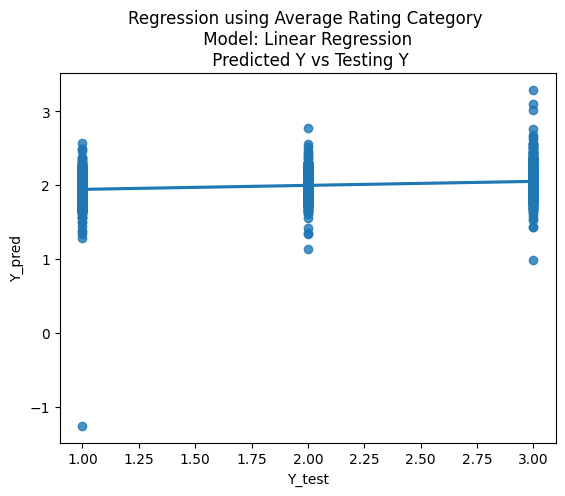

In [58]:
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'])

Coefficients: 
 [ 1.34851644e+00 -1.33413630e+00  7.28918384e-02 -4.94149130e-03
  1.91866103e-04  5.48979091e-03 -2.00973838e-02 -4.48387808e-03
  1.90914710e-02]
Mean squared error: 0.08
Coefficient of determination: 0.06
3.8537844452881695


,Coefficient
log_ratings_count,1.348516
log_total_reviews,-1.334136
multiple_authors,0.072892
n_authors,-0.004941
max_pages,0.000192
season_num_1,0.005490
season_num_2,-0.020097
season_num_3,-0.004484
season_num_4,0.019091


{'model': LinearRegression(),
 'Y_pred': array([3.94064578, 3.89126824, 3.98388556, ..., 3.86648777, 3.89278853,
        3.84715645]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     1.348516
 log_total_reviews    -1.334136
 multiple_authors      0.072892
 n_authors            -0.004941
 max_pages             0.000192
 season_num_1          0.005490
 season_num_2         -0.020097
 season_num_3         -0.004484
 season_num_4          0.019091}

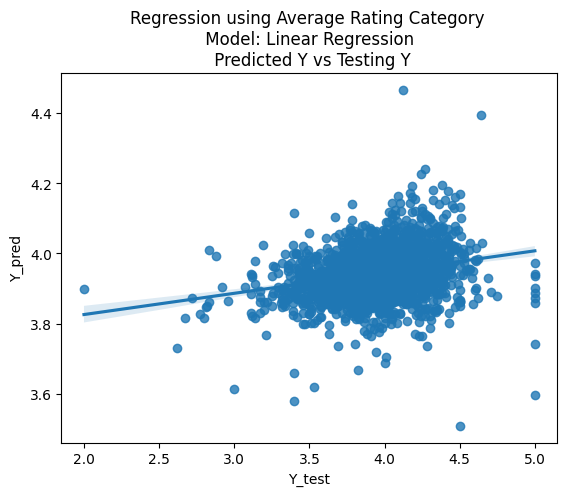

In [59]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'])

Coefficients: 
 [ 2.92682464e+00 -2.89664274e+00  2.06555201e-01 -7.29233021e-03
  4.60145164e-04  1.78327437e+00  1.72549166e+00  1.74870805e+00
  1.80258061e+00]
Mean squared error: 0.64
Coefficient of determination: 0.05
0.0


,Coefficient
log_ratings_count,2.926825
log_total_reviews,-2.896643
multiple_authors,0.206555
n_authors,-0.007292
max_pages,0.000460
season_num_1,1.783274
season_num_2,1.725492
season_num_3,1.748708
season_num_4,1.802581


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([2.07617242, 1.92225438, 1.96975158, ..., 2.14756346, 1.92006045,
        1.91744622]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     2.926825
 log_total_reviews    -2.896643
 multiple_authors      0.206555
 n_authors            -0.007292
 max_pages             0.000460
 season_num_1          1.783274
 season_num_2          1.725492
 season_num_3          1.748708
 season_num_4          1.802581}

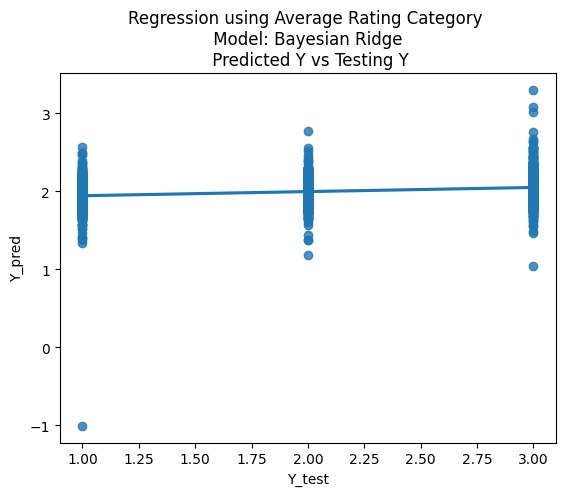

In [60]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(tol=1e-6, fit_intercept=False, compute_score=True)
perform_linear_regression(regression_dataset_avg_rating_cat_dict['X_train'],regression_dataset_avg_rating_cat_dict['Y_train'],regression_dataset_avg_rating_cat_dict['X_test'], regression_dataset_avg_rating_cat_dict['Y_test'],regression_dataset_avg_rating_cat_dict['name'], model_name='Bayesian Ridge',model=reg)


Coefficients: 
 [ 1.34131144e+00 -1.32683305e+00  7.29387543e-02 -4.93199040e-03
  1.92010191e-04  3.85866446e+00  3.83307114e+00  3.84868906e+00
  3.87225643e+00]
Mean squared error: 0.08
Coefficient of determination: 0.06
0.0


,Coefficient
log_ratings_count,1.341311
log_total_reviews,-1.326833
multiple_authors,0.072939
n_authors,-0.004932
max_pages,0.000192
season_num_1,3.858664
season_num_2,3.833071
season_num_3,3.848689
season_num_4,3.872256


{'model': BayesianRidge(compute_score=True, fit_intercept=False, tol=1e-06),
 'Y_pred': array([3.94039881, 3.89127449, 3.98392425, ..., 3.86635312, 3.89282385,
        3.84709349]),
 'Coefficients_dataset':                    Coefficient
 log_ratings_count     1.341311
 log_total_reviews    -1.326833
 multiple_authors      0.072939
 n_authors            -0.004932
 max_pages             0.000192
 season_num_1          3.858664
 season_num_2          3.833071
 season_num_3          3.848689
 season_num_4          3.872256}

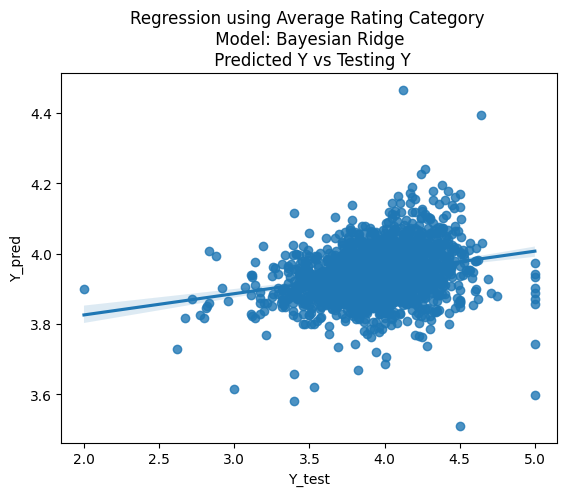

In [61]:
perform_linear_regression(regression_dataset_avg_rating_dict['X_train'],regression_dataset_avg_rating_dict['Y_train'],regression_dataset_avg_rating_dict['X_test'], regression_dataset_avg_rating_dict['Y_test'],regression_dataset_avg_rating_dict['name'], model_name='Bayesian Ridge',model=reg)

## Classification
3. Random Forest
4. AdaBoost


In [170]:
featured_columns = ['language_code', 'genre', 'multiple_authors', 'n_authors', 'max_pages','avg_rating_author', 'pub_month',
       'pub_year', 'season_num', 'log_ratings_count', 'ratings_count_category', 'log_text_reviews_count_updt',
       'log_total_reviews', 'average_rating_three_cat_T']


In [171]:

classification_dataset = clean_dataset[featured_columns]

display(classification_dataset.head())

,language_code,genre,multiple_authors,n_authors,max_pages,avg_rating_author,pub_month,pub_year,season_num,log_ratings_count,ratings_count_category,log_text_reviews_count_updt,log_total_reviews,average_rating_three_cat_T
0,en-us,food,0,1,192,4.22,9,2003,4,3.441239,medium high,2.330617,3.473648,3.0
1,eng,art,0,1,528,3.49,5,2003,2,1.478566,low,0.612784,1.532754,1.0
2,eng,autobiography-biography,0,1,817,3.98,10,1975,4,4.933751,high,2.917033,4.937909,2.0
3,eng,guidebook,0,1,992,3.85,5,2003,2,4.559944,high,2.642563,4.565164,2.0
4,eng,mystery,0,1,320,3.96,8,2004,3,3.542838,medium high,2.248219,3.564323,2.0


In [173]:
featured_columns = ['language_code', 'genre', 'multiple_authors', 'n_authors', 'max_pages', 'author','avg_rating_author', 'pub_month',
       'pub_year', 'season_num', 'log_ratings_count', 'ratings_count_category', 'log_text_reviews_count_updt',
       'log_total_reviews', 'average_rating_three_cat_T']


In [188]:
classification_dataset = classification_dataset.dropna()

classification_dataset_dummies = from_categoric_to_dummies(['language_code','genre','pub_month','season_num','ratings_count_category'],classification_dataset)
classification_dataset_dummies.columns


Index(['multiple_authors', 'n_authors', 'max_pages', 'avg_rating_author',
       'pub_year', 'log_ratings_count', 'log_text_reviews_count_updt',
       'log_total_reviews', 'average_rating_three_cat_T', 'language_code_ara',
       'language_code_en-ca', 'language_code_en-gb', 'language_code_en-us',
       'language_code_eng', 'language_code_enm', 'language_code_fre',
       'language_code_ger', 'language_code_gla', 'language_code_glg',
       'language_code_grc', 'language_code_ita', 'language_code_jpn',
       'language_code_lat', 'language_code_msa', 'language_code_mul',
       'language_code_nl', 'language_code_nor', 'language_code_por',
       'language_code_rus', 'language_code_spa', 'language_code_swe',
       'language_code_tur', 'language_code_wel', 'language_code_zho',
       'genre_action-adventure', 'genre_art', 'genre_autobiography-biography',
       'genre_business-economy', 'genre_comics', 'genre_drama', 'genre_essay',
       'genre_fable-fairytale', 'genre_fantasy', 'gen

In [189]:

classification_dataset_cat_dict = prepare_dataset_for_linear_regression(classification_dataset_dummies,'average_rating_three_cat_T',0.2,'Classification - Featured Engineered')


10281

8224

2057

,average_rating,log_ratings_count,log_total_reviews,multiple_authors,n_authors,max_pages,season_num,average_rating_three_cat_T
count,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000,10281.000000
mean,3.942800,2.908658,2.938936,0.398016,1.712966,338.565898,2.602471,1.990857
std,0.297308,1.207651,1.198812,0.489513,1.842272,239.349215,1.138737,0.819102
min,1.670000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,3.770000,2.057286,2.100715,0.000000,1.000000,199.000000,2.000000,1.000000
50%,3.960000,2.947483,2.975937,0.000000,1.000000,301.000000,3.000000,2.000000
75%,4.140000,3.768053,3.788953,1.000000,2.000000,416.000000,4.000000,3.000000
max,5.000000,6.662537,6.671352,1.000000,51.000000,6576.000000,4.000000,3.000000


,multiple_authors,n_authors,max_pages,avg_rating_author,pub_year,log_ratings_count,log_text_reviews_count_updt,log_total_reviews,average_rating_three_cat_T,language_code_ara,...,season_num_1,season_num_2,season_num_3,season_num_4,ratings_count_category_high,ratings_count_category_low,ratings_count_category_medium,ratings_count_category_medium high,ratings_count_category_very high,ratings_count_category_very low
count,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,...,8224.000000,8224.000000,8224.000000,8224.00000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000,8224.000000
mean,0.397130,1.708658,337.080253,3.943361,1999.967656,2.911005,1.656492,2.941163,1.993312,0.000122,...,0.222519,0.247082,0.223249,0.30715,0.155277,0.176070,0.284047,0.292072,0.034776,0.057758
std,0.489333,1.825940,238.555743,0.255081,8.349150,1.205346,1.116736,1.196665,0.820999,0.011027,...,0.415963,0.431341,0.416449,0.46134,0.362191,0.380903,0.450987,0.454743,0.183224,0.233299
min,0.000000,1.000000,1.000000,1.980000,1900.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,196.000000,3.807500,1998.000000,2.057286,0.959041,2.100715,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,299.000000,3.960000,2002.000000,2.946992,1.716838,2.976854,2.000000,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,414.250000,4.100000,2005.000000,3.764314,2.425045,3.784714,3.000000,0.000000,...,0.000000,0.000000,0.000000,1.00000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,51.000000,6576.000000,5.000000,2020.000000,6.662537,4.974351,6.671352,3.000000,1.000000,...,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,multiple_authors,n_authors,max_pages,avg_rating_author,pub_year,log_ratings_count,log_text_reviews_count_updt,log_total_reviews,average_rating_three_cat_T,language_code_ara,...,season_num_1,season_num_2,season_num_3,season_num_4,ratings_count_category_high,ratings_count_category_low,ratings_count_category_medium,ratings_count_category_medium high,ratings_count_category_very high,ratings_count_category_very low
count,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.0,...,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000,2057.000000
mean,0.401556,1.730190,344.505591,3.932037,1999.978123,2.899273,1.655786,2.930033,1.981040,0.0,...,0.242586,0.244045,0.231891,0.281478,0.161886,0.179387,0.276616,0.291687,0.032086,0.058337
std,0.490332,1.906529,242.463227,0.256239,8.505892,1.217073,1.113841,1.207606,0.811595,0.0,...,0.428751,0.429624,0.422142,0.449829,0.368436,0.383770,0.447434,0.454649,0.176270,0.234437
min,0.000000,1.000000,1.000000,1.670000,1919.000000,-1.000000,-1.000000,-1.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,206.000000,3.800000,1998.000000,2.057286,0.959041,2.097257,1.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,304.000000,3.940000,2003.000000,2.951386,1.725095,2.974097,2.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,2.000000,416.000000,4.080000,2005.000000,3.794077,2.434729,3.813588,3.000000,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,33.000000,3400.000000,5.000000,2017.000000,6.390421,4.938925,6.398043,3.000000,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [190]:
classification_dataset.isnull().values.any()
classification_dataset.isnull().sum().sum()

0

In [191]:
classification_dataset_cat_dict

{'name': 'Classification - Featured Engineered',
 'X_train':        multiple_authors  n_authors  max_pages  avg_rating_author  pub_year  \
 2759                  0          1        272               3.79      2002   
 1322                  0          1        239               4.04      2005   
 6918                  0          1        144               3.94      1990   
 3229                  0          1        149               4.17      2005   
 4247                  1          2         96               3.56      2001   
 ...                 ...        ...        ...                ...       ...   
 868                   0          1        416               3.61      1991   
 1321                  1          2        320               4.05      2006   
 10117                 1          2        768               4.01      2002   
 6585                  0          1        776               4.07      2004   
 6940                  1          2        195               4.31      

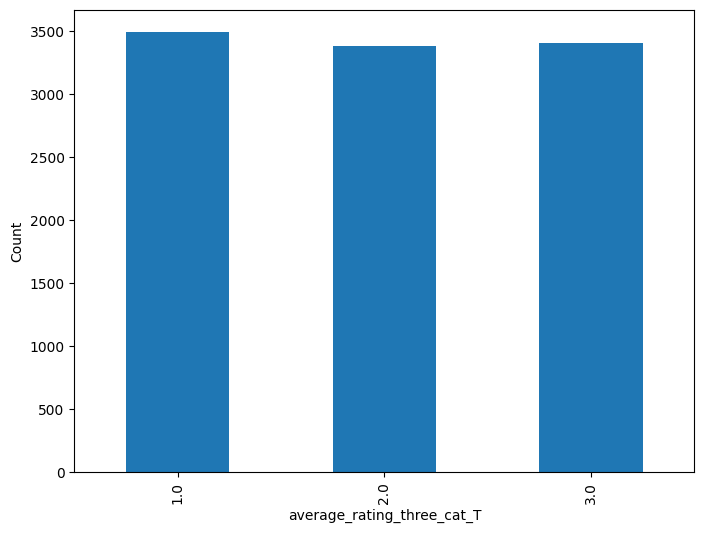

In [192]:
fig, ax = plt.subplots(figsize=(8,6))
classification_dataset_dummies.groupby(['average_rating_three_cat_T'])['average_rating_three_cat_T'].count().plot(kind='bar')
#plt.xticks([0,1],['Legal (0)','Fraud (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

In [193]:
from sklearn.manifold import TSNE
X = classification_dataset_dummies.loc[:, classification_dataset_dummies.columns != 'average_rating_three_cat_T']
y = classification_dataset_dummies.loc[:, classification_dataset_dummies.columns == 'average_rating_three_cat_T']

X = X.to_numpy()
y = y.to_numpy()
y = y.T[0]

tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X)

colors = []
for i in y:
    if i == 1.0:
        colors.append('R')
    elif i == 2.0:
        colors.append('B')
    else:
        colors.append('G')


df_tsne = pd.DataFrame(matrix_2d)
df_tsne['average_rating_three_cat_T'] = classification_dataset_dummies['average_rating_three_cat_T']
df_tsne['color'] = colors
df_tsne.columns = ['x','y','average_rating_three_cat_T','color']
cols = ['average_rating_three_cat_T','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,average_rating_three_cat_T,color,x,y
0,3.0,G,-27.088942,-58.668327
1,1.0,R,55.437561,-2.476110
2,2.0,B,77.298904,31.085243
3,2.0,B,99.260788,21.447474
4,2.0,B,14.831663,-17.275043


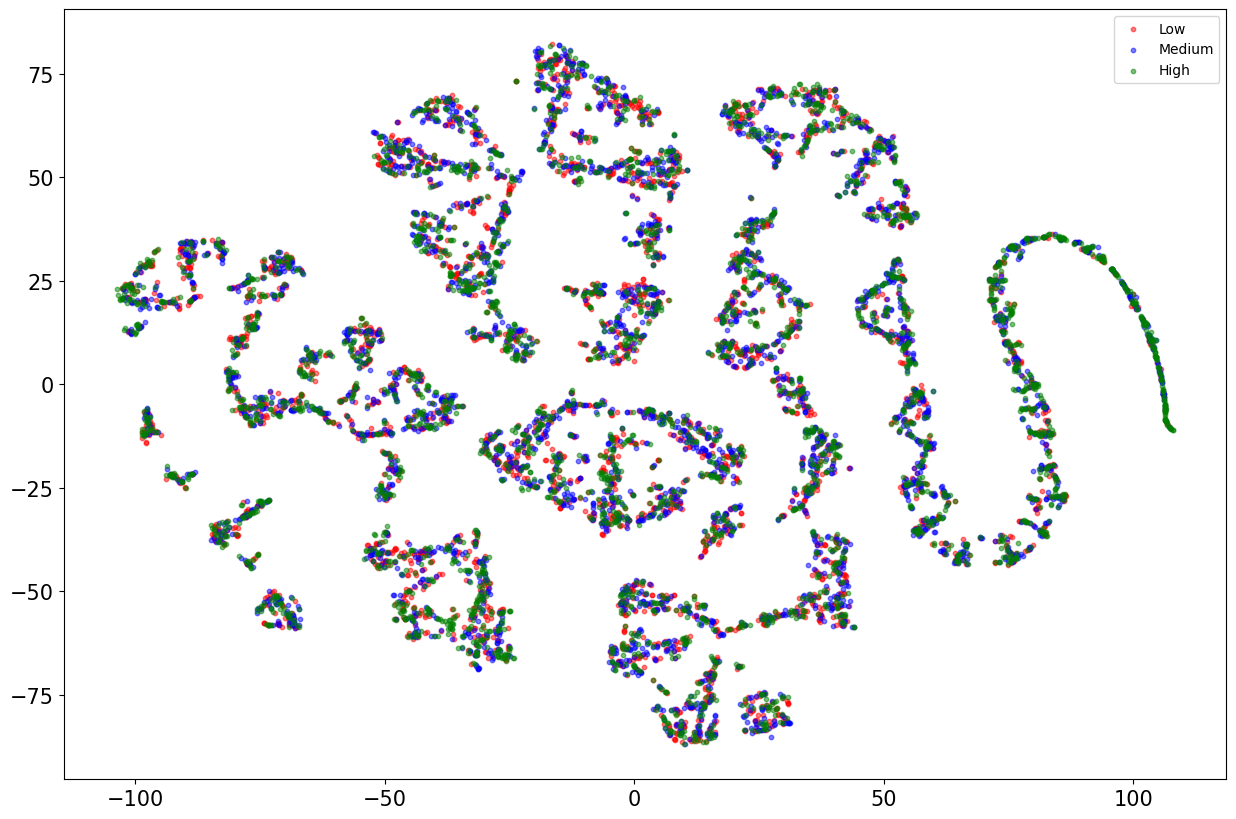

In [194]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==1.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==1.0].y.values,
           c='red', s=10, alpha=0.5, label='Low')
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==2.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==2.0].y.values,
           c='blue', s=10, alpha=0.5, label='Medium')
ax.scatter(df_tsne[df_tsne['average_rating_three_cat_T']==3.0].x.values, df_tsne[df_tsne['average_rating_three_cat_T']==3.0].y.values,
           c='green', s=10, alpha=0.5, label='High')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show()

In [195]:
np.logspace(start=1,stop=3.478,num=20)

array([  10.        ,   13.50271349,   18.23232716,   24.618589  ,
         33.24177538,   44.88541688,   60.60749241,   81.83656055,
        110.50156302,  149.20709458,  201.47006489,  272.03925633,
        367.32681366,  495.99087224,  669.72226422,  904.30678524,
       1221.05954293, 1648.76171638, 2226.27570716, 3006.07630263])

In [196]:
classification_dataset_cat_dict.keys()
X_train = classification_dataset_cat_dict['X_train']
y_train = classification_dataset_cat_dict['Y_train']
X_test = classification_dataset_cat_dict['X_test']
y_test = classification_dataset_cat_dict['Y_test']



In [197]:
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score

scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs=-1)
    model = clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds, average="micro")
    recall = recall_score(y_test, preds, average="micro")
    f1 = f1_score(y_test, preds, average="micro")
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

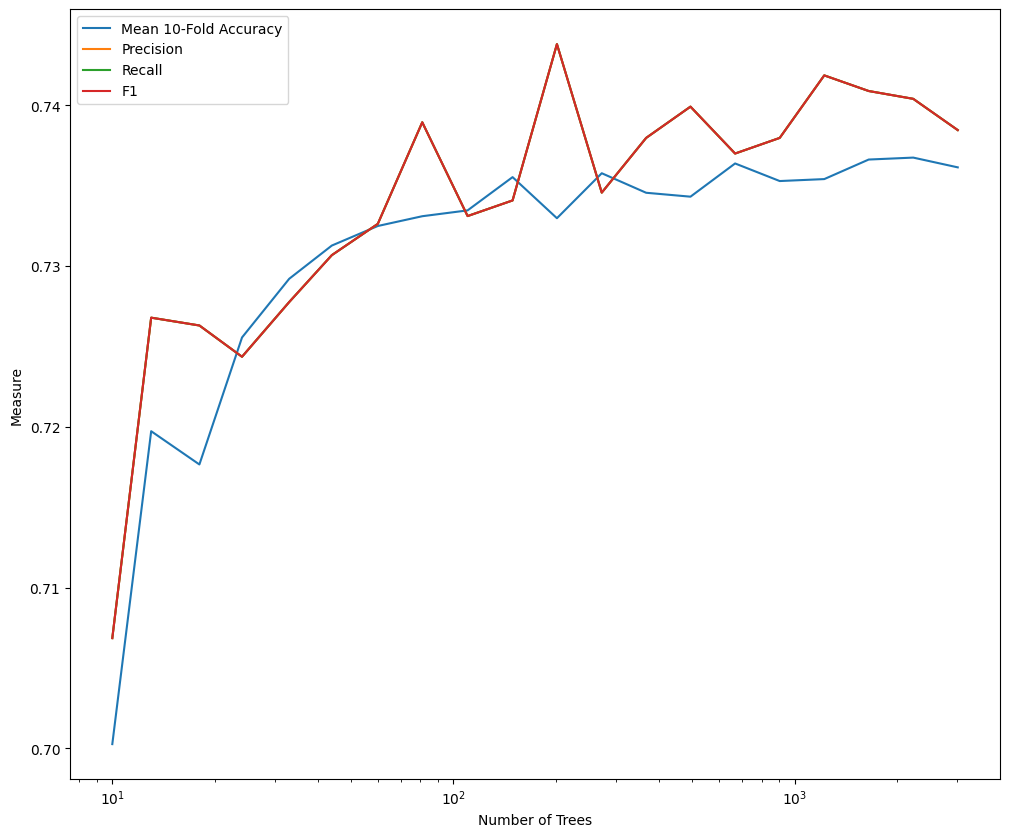

In [203]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Measure')
# ax.set_ylim(0.89,1.)
plt.show()

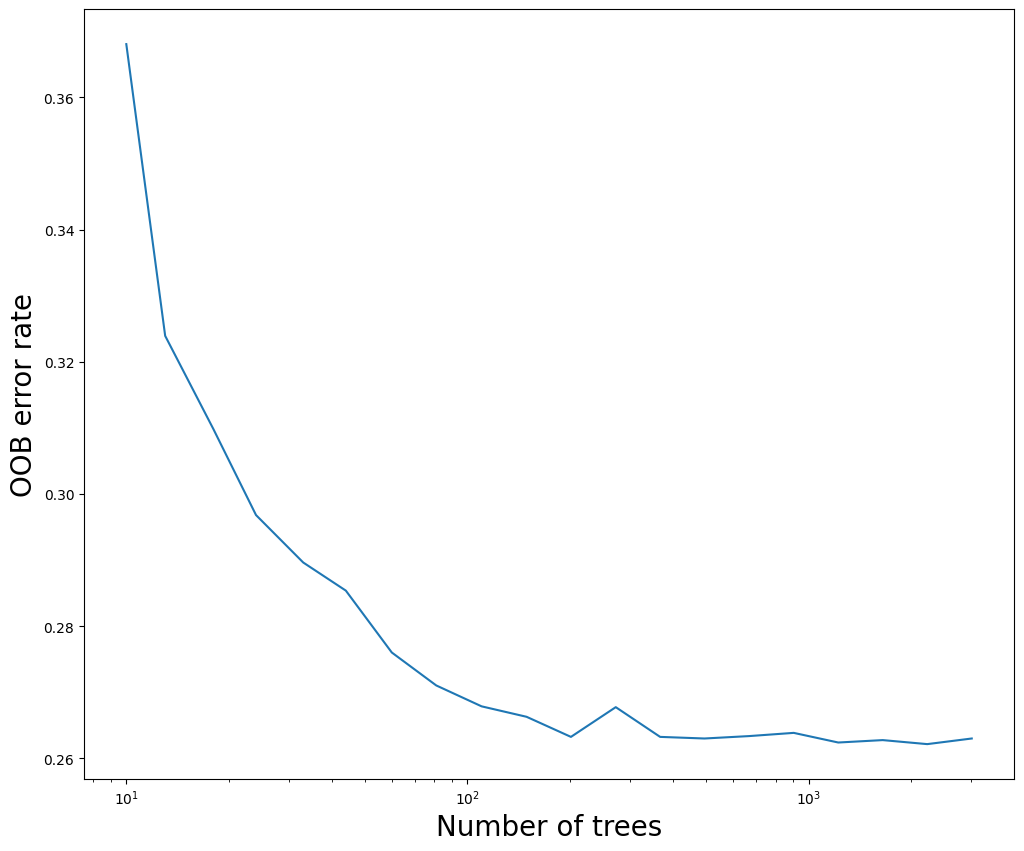

In [204]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)
plt.show()

In [205]:
N_trees = 400
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy')
model = clf.fit(X_train, y_train)
preds = model.predict(X_test)

In [206]:
import itertools

def plot_confusion_matrix(confusion_matrix, target_names, title='Confusion matrix',cmap=plt.cm.Blues, normalized=False):
    """
    This function prints and plots the confusion matrix
    """
    accuracy = np.trace(confusion_matrix) / np.sum(confusion_matrix).astype('float')
    misclass = 1 - accuracy
    fig, ax = plt.subplots(figsize=(15,10))
    
    if normalized == True:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
        confusion_matrix = np.round_(confusion_matrix, decimals=3)
    
    ax.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)

    thresh = confusion_matrix.max() / 2.
    for i, j in itertools.product(range(confusion_matrix.shape[0]), range(confusion_matrix.shape[1])):
        plt.text(j, i, confusion_matrix[i, j],
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    ax.grid(False)
    plt.show()

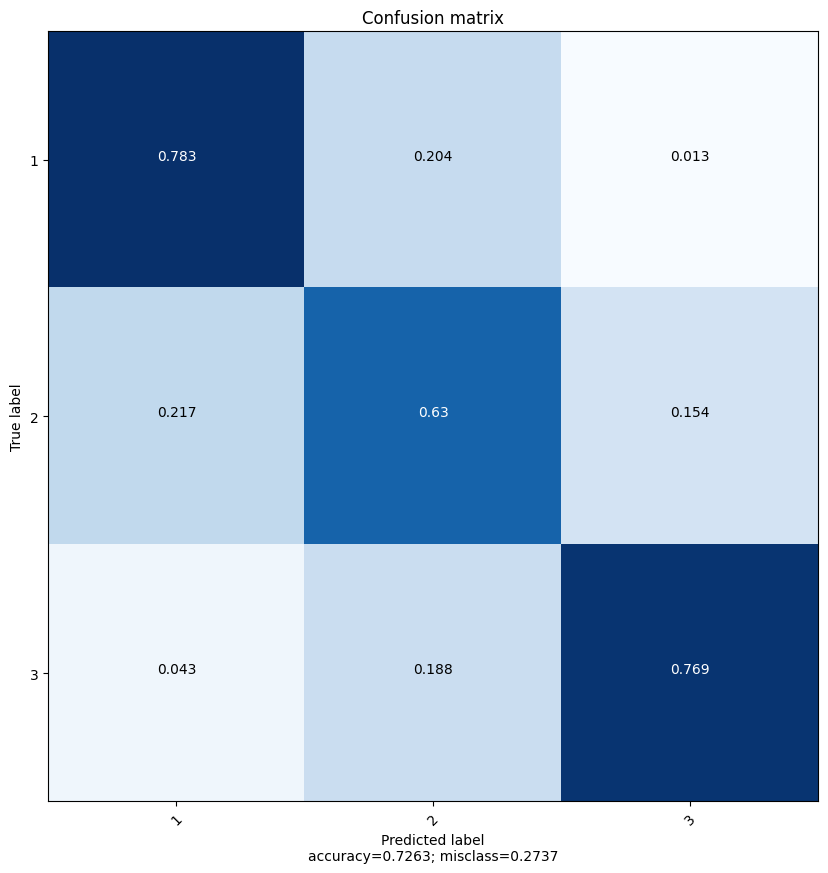

In [207]:
conf_matrix = confusion_matrix(y_test,model.predict(X_test))
target_names = [1,2,3]
plot_confusion_matrix(conf_matrix, target_names=class_names, title='Confusion matrix', normalized=True)

In [220]:
print("Recall:", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[1][0]))
print("Precision:", conf_matrix[1][1]/(conf_matrix[1][1]+conf_matrix[0][1]))

Recall: 0.7441077441077442
Precision: 0.7568493150684932


In [217]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier


# define and train models

rf_model = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy', random_state=42).fit(X_train, y_train)
ab_model = AdaBoostClassifier(random_state=42).fit(X_train, y_train)

# make predictions
ab_preds = ab_model.predict(X_test)
rf_preds = rf_model.predict(X_test)




# compute performance metrics
def print_metrics(y_true, y_pred):

    cf = pd.DataFrame(
    columns=["Pred_1","Pred_2","Pred_3"],index=["True_1","True_2","True_3"])
    cf.loc[:,:] = confusion_matrix(y_true= y_true,y_pred= y_pred)
    print(cf/len(y_true))
    report =classification_report(y_true=y_true, y_pred=y_pred)
    print(report)


print("AdaBoost Metrics:")
print_metrics(y_test, ab_preds)

print("Random Forest Metrics:")
print_metrics(y_test, rf_preds)




AdaBoost Metrics:
          Pred_1    Pred_2    Pred_3
True_1  0.244531  0.091395  0.002917
True_2   0.05299  0.244045  0.044239
True_3  0.013126  0.067088  0.239669
              precision    recall  f1-score   support

         1.0       0.79      0.72      0.75       697
         2.0       0.61      0.72      0.66       702
         3.0       0.84      0.75      0.79       658

    accuracy                           0.73      2057
   macro avg       0.74      0.73      0.73      2057
weighted avg       0.74      0.73      0.73      2057

Random Forest Metrics:
          Pred_1    Pred_2    Pred_3
True_1  0.263491  0.070977  0.004375
True_2  0.062227  0.231891  0.047156
True_3  0.013612  0.064171    0.2421
              precision    recall  f1-score   support

         1.0       0.78      0.78      0.78       697
         2.0       0.63      0.68      0.65       702
         3.0       0.82      0.76      0.79       658

    accuracy                           0.74      2057
   macro a

In [219]:
# decision tree  on imbalanced dataset with SMOTE oversampling and random undersampling
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# define dataset

# define pipeline
model = AdaBoostClassifier()
over = SMOTE(sampling_strategy="auto")
under = RandomUnderSampler(sampling_strategy="auto")
steps = [('over', over), ('under', under), ('model', model)]
pipeline = Pipeline(steps=steps)
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
print('Mean ROC AUC: %.3f' % mean(scores))
k_values = [1, 2, 3, 4, 5, 6, 7]
for k in k_values:
	# define pipeline
	model = AdaBoostClassifier()
	over = SMOTE(sampling_strategy="auto", k_neighbors=k)
	under = RandomUnderSampler(sampling_strategy="auto")
	steps = [('over', over), ('under', under), ('model', model)]
	pipeline = Pipeline(steps=steps)
	# evaluate pipeline
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(pipeline, X_train, Y_train, cv=cv, n_jobs=-1, error_score="raise", verbose=1)
	score = mean(scores)
	print('> k=%d, Mean ROC AUC: %.3f' % (k, score))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Mean ROC AUC: 0.330


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=1, Mean ROC AUC: 0.329


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=2, Mean ROC AUC: 0.332


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=3, Mean ROC AUC: 0.331


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=4, Mean ROC AUC: 0.329


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=5, Mean ROC AUC: 0.326


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


> k=6, Mean ROC AUC: 0.333
> k=7, Mean ROC AUC: 0.330


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.5s finished
